# Randomised benchmarking
This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/5a_randomized_benchmarking.ipynb).

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_london


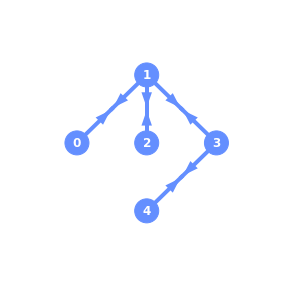

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration.
print(backend)
plot_gate_map(backend, plot_directed=True)

## Standard RB

In [4]:
import qiskit.ignis.verification.randomized_benchmarking as rb

# Parameters for the RB run:
nqs = 1                              # no. of qubits.
nseeds = 5                           # no. of random seeds.
ncliffs = np.arange(1, 200, 20)      # no. of Cliffords per sequence.
rb_pattern = [[0], [1, 2]]           # Which sets of qubits to benchmark.
length_multiplier = [3, 1]           # Scale factor for sequence length.

In [5]:
rb_opts = {}
rb_opts['length_vector'] = ncliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier

# Generate RB sequences.
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)
print(rb_circs[0][0])

Making the n=2 Clifford Table
         ┌─────┐┌───┐ ░ ┌─────┐┌───┐┌───┐ ░ ┌───┐┌─────┐┌───┐┌───┐ ░ ┌───┐»
qr_0: |0>┤ Sdg ├┤ H ├─░─┤ Sdg ├┤ H ├┤ Z ├─░─┤ H ├┤ Sdg ├┤ H ├┤ Y ├─░─┤ Y ├»
         └┬───┬┘├───┤ ░ └┬───┬┘├───┤└┬─┬┘ ░ └───┘└─────┘└───┘└───┘ ░ └───┘»
qr_1: |0>─┤ H ├─┤ Z ├─░──┤ Z ├─┤ H ├─┤M├──────────────────────────────────»
          ├───┤ └───┘ ░  ├───┤ └┬─┬┘ └╥┘                                  »
qr_2: |0>─┤ H ├───────░──┤ H ├──┤M├───╫───────────────────────────────────»
          └───┘       ░  └───┘  └╥┘   ║                                   »
 cr_0: 0 ════════════════════════╬════╬═══════════════════════════════════»
                                 ║    ║                                   »
 cr_1: 0 ════════════════════════╬════╩═══════════════════════════════════»
                                 ║                                        »
 cr_2: 0 ════════════════════════╩════════════════════════════════════════»
                                                          

In [6]:
# Run RB sequences.
result = []
for circ in rb_circs:
    job = execute(circ, backend, optimization_level=0, shots=5000)
    result.append(job.result())
    print(job.job_id())

5e4a1461d686050018c27b82
5e4a14d794160a00181d653b
5e4a1545b88f610018f99e86
5e4a15b7b88f610018f99e89
5e4a1628f451ab00187ecf07


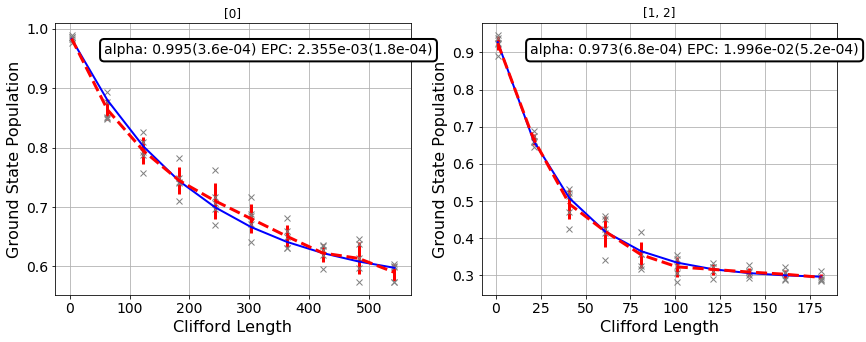

In [7]:
# Calculate exponential fit.
rb_fit = rb.fitters.RBFitter(result, xdata, rb_opts['rb_pattern'])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for idx in range(2):
    rb_fit.plot_rb_data(idx, axs[idx], show_plt = False)
    axs[idx].set_title(str(rb_pattern[idx]))

## Interleaved RB

In [8]:
import os
import qiskit.ignis.verification.randomized_benchmarking as rb

# Parameters for the RB run:
nqs = 1                                            
nseeds = 5                                         
ncliffs = np.arange(1, 200, 20)                    
rb_pattern = [[0], [1, 2]]                         
length_multiplier = [3, 1]                         
interleaved_gates = [['h 0'], ['cx 0 1']]          # Interleaved gates for each set of qubits.

In [9]:
rb_opts = {}
rb_opts['length_vector'] = ncliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_opts['interleaved_gates'] = interleaved_gates

# Generate standard and interleaved RB circuits.
rb_circs, xdata, irb_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [11]:
# Run standard RB sequences.
result = []
for circ in rb_circs:
    os.environ['QISKIT_IN_PARALLEL'] = 'TRUE' # This stops Qiskit yelling at me.
    job = execute(circ, backend, optimization_level=0, shots=5000)
    result.append(job.result()) # Loop will pause until results can be retrieved.
    print(job.job_id())

5e4a1bb0f451ab00187ecf28
5e4a1c21c3369900189f4414
5e4a1c9594160a00181d6577
5e4a1d05ea11110018f000b8
5e4a1d7b912c8200183cb301


In [12]:
# Run interleaved RB sequences.
iresult = []
for circ in irb_circs:
    os.environ['QISKIT_IN_PARALLEL'] = 'TRUE' # This stops Qiskit yelling at me.
    job = execute(circ, backend, optimization_level=0, shots=5000)
    iresult.append(job.result()) # Loop will pause until results can be retrieved.
    print(job.job_id())

5e4a1df3912c8200183cb306
5e4a1e76e2319f0018fea1cb
5e4a1effea11110018f000c7
5e4a1f7ef451ab00187ecf3f
5e4a1ff87bc87b001851705c


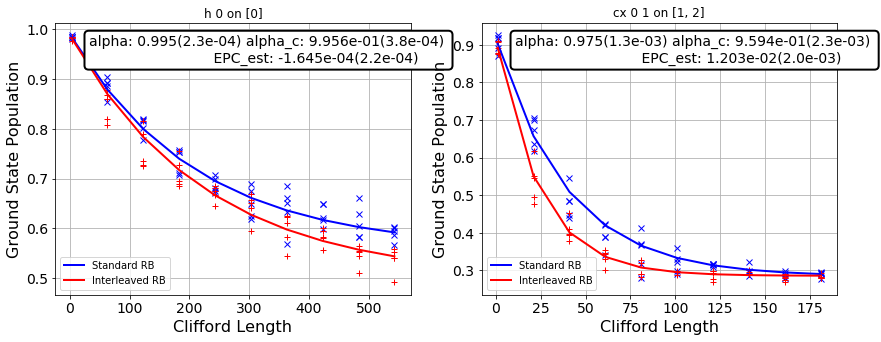

In [13]:
# Calculate exponential fit.
rb_fit = rb.RBFitter(result, xdata, rb_opts['rb_pattern'])
irb_fit = rb.RBFitter(iresult, xdata, rb_opts['rb_pattern'])

joint_rb_fit = rb.InterleavedRBFitter(result, iresult, xdata, rb_opts['rb_pattern'])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for idx in range(2):
    joint_rb_fit.plot_rb_data(idx, axs[idx], show_plt = False)
    axs[idx].set_title(interleaved_gates[idx][0]+' on '+str(rb_pattern[idx]))